In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf, keras
from keras import optimizers, models, layers
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.mobilenet import preprocess_input
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.python.keras import backend as K
from tensorflow.keras.preprocessing import image
from mlxtend.evaluate import confusion_matrix
import matplotlib.image as mpimg

# processing image
import cv2
import glob

In [76]:
data_train = "../input/new-sgan-dataset/SGAN_Dataset/Fake"
data_real_fp = "../input/new-sgan-dataset/SGAN_Dataset/Live"

# Iteration
epochs = 15

# length and height of matriz of the convolution
length, height = 200, 200

# type class
Type_class = 12

# learning rate
lr = 0.0005


In [77]:

DataGenerator_train = ImageDataGenerator(
    shear_range = 0.3, # tilt images
    zoom_range = 0.3, # lots of images
    horizontal_flip = True,
    cval=0.7
)

img_train = DataGenerator_train.flow_from_directory(
    data_train,
    batch_size=2000,
    target_size=(height, length),
    class_mode="categorical")

DataGenerator_realfp = ImageDataGenerator(
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    cval=.7
)

real_fp = DataGenerator_realfp.flow_from_directory(
    data_real_fp,
    batch_size = 2000,
    target_size=(height, length),
    class_mode=None
)

print(img_train.class_indices)

Found 20182 images belonging to 12 classes.
Found 0 images belonging to 0 classes.
{'BodyDouble': 0, 'Ecoflex': 1, 'Gelatin': 2, 'Latex': 3, 'Liquid_Ecoflex': 4, 'Modasil': 5, 'OOMOO': 6, 'Playdoh': 7, 'RTV': 8, 'Silgum': 9, 'Silicone': 10, 'WoodGlue': 11}


In [51]:
# Normalize of data image
def normalize(images):
    
    ROI=list()
    clipped=list()
    ImgResult=list()
    mean, STD=cv2.meanStdDev(images[0].astype(float))

    for iter in range(0, images.astype(float).shape[0]):
        ROI.append(images[iter].astype(float))
        pass
    
    offset=0.2
    ROI=np.asarray(ROI)
    
    X_nw = []
    for nter in range(0, ROI.shape[0]):
        clipped.append(np.clip(ROI[nter],
                       mean[0] - offset * STD[0],
                       mean[0] + offset * STD[0]).astype(np.float32))
        ImgResult.append(cv2.normalize(clipped[nter],
                                clipped[nter], 
                                alpha=0, 
                                beta=200,
                                       norm_type=cv2.NORM_MINMAX))
        # resize from 200X200 to 60X60
        #X_nw.append(cv2.resize(ImgResult[nter], (0, 0), fx=.14, fy=.14))
        pass
    ImgResult=np.asarray(ImgResult)
    return ImgResult

In [72]:
data, labels = next(img_train)
trainX, testX, trainy, testy = train_test_split(data, 
                                                labels,
                                                test_size=0.2,
                                                shuffle=False)

In [53]:
def load_real_samples(trainX, trainy):
    
    # expand to 3 dimensions
    X = np.expand_dims(trainX, axis=-1)
    print(X.shape)
    X=trainX.astype('float32')
    
    X=np.asarray(X)
    X=normalize(X)
    
    #X=X[:, :, :, 0]
    #R, G, B = X.shape
    #X = X.reshape(R, G, B, 1)
    # Escale from [0,255] to [-1, 1]
    X = (X - np.amin(X)) / (np.amax(X) - np.amin(X))*-1
    
    trainy = trainy[:, 0]
    
    print(X.shape, trainy.shape)
    return [X, trainy]


In [54]:
# custom activation function
def custom_activation(output):
    logexpsum = keras.backend.sum(keras.backend.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

def define_discriminator(in_shape=(200, 200, 3), n_classes=Type_class):
    
    # image input
    in_image = layers.Input(shape=in_shape)
    
    fe = layers.Conv2D(128, (3,3),
                       strides=(2,2),
                       padding='same')(in_image)
    fe = layers.LeakyReLU(alpha=0.2)(fe)
    
    fe = layers.Conv2D(128, (3,3),
                       strides=(2,2), 
                       padding='same')(fe)
    fe = layers.LeakyReLU(alpha=0.2)(fe)
        
    # flatten feature maps
    fe = layers.Flatten()(fe)
    # dropout
    fe = layers.Dropout(0.4)(fe)
    # output layer nodes
    fe = layers.Dense(n_classes)(fe)
    # supervised output
    c_out_layer = layers.Activation('softmax')(fe)
    # define and compile supervised discriminator model
    c_model = models.Model(in_image, c_out_layer)
    c_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=optimizers.Adam(lr=lr, beta_1=0.5),
                    metrics=['accuracy'])
    # unsupervised output
    d_out_layer = layers.Lambda(custom_activation)(fe)
    # define and compile unsupervised discriminator model
    d_model = models.Model(in_image, d_out_layer)
    d_model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.Adam(lr=lr,
                                              beta_1=0.5))
    return d_model, c_model

d_model, c_model = define_discriminator()
# plot the model
d_model_plot = plot_model(d_model,
           to_file='stacked_discriminator1_plot.png', 
           show_shapes=True, 
           show_layer_names=True)

c_model_plot = plot_model(c_model, 
           to_file='stacked_discriminator2_plot.png', 
           show_shapes=True, 
           show_layer_names=True)

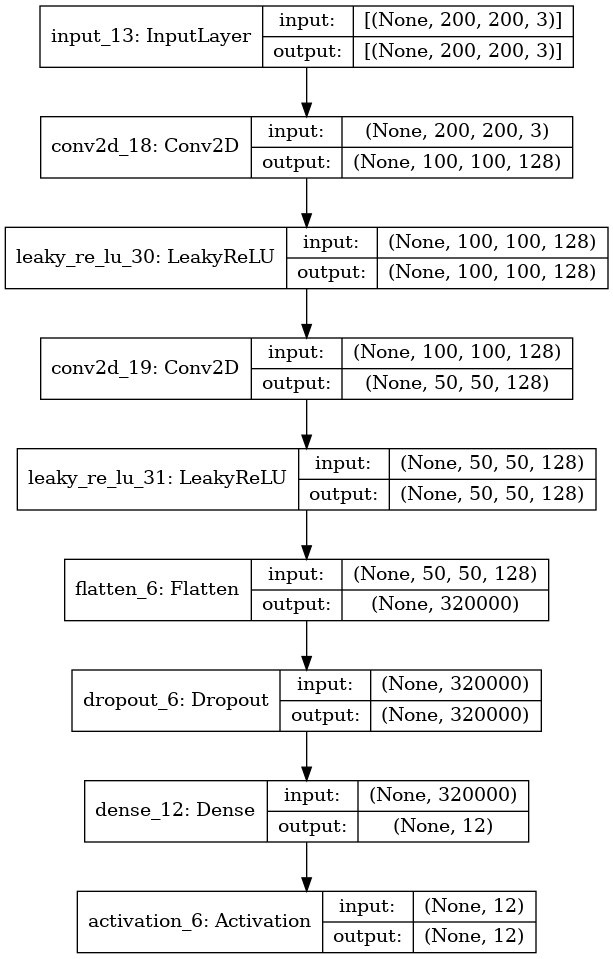

In [55]:
# impresion de las capas

c_model_plot

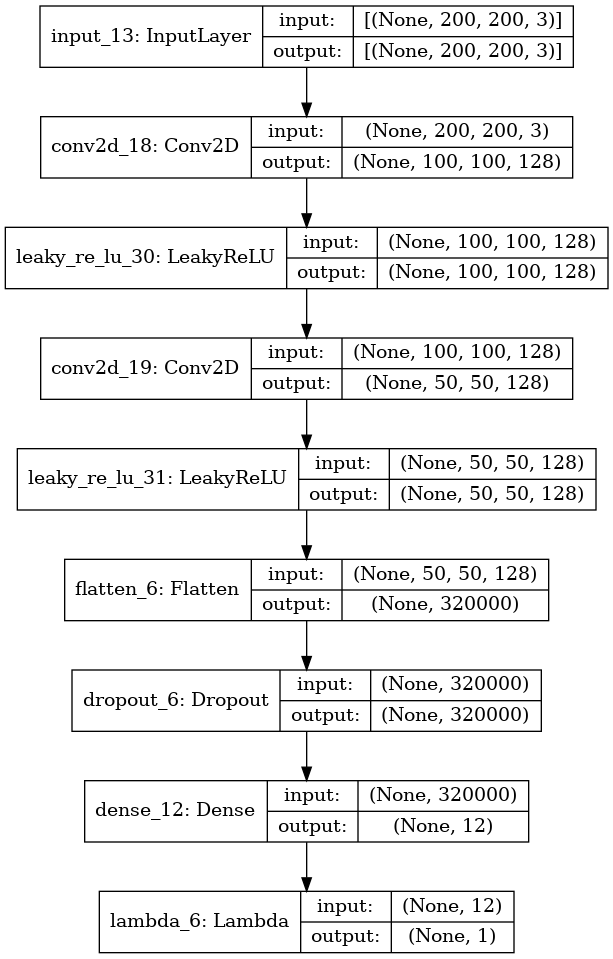

In [56]:
d_model_plot

In [57]:
def define_generator(latent_dim):
    
    in_lat=layers.Input(shape=(latent_dim, ))
    
    # image 50 x 50
    n_nodes= 128 * 50 * 50
    gen=layers.Dense(n_nodes)(in_lat)
    gen=layers.LeakyReLU(alpha=0.2)(gen)
    gen=layers.Reshape((50, 50, 128))(gen)
    
    # redim images de 100 x 100
    gen=layers.Conv2DTranspose(128, (4, 4), 
                              strides=(2, 2),
                              padding='same')(gen)
    gen=layers.LeakyReLU(alpha=0.2)(gen)
    
    # redim to 200 x 200
    gen=layers.Conv2DTranspose(128, (4, 4), 
                             strides=(2, 2),
                             padding='same')(gen)
    gen=layers.LeakyReLU(alpha=0.2)(gen)
    
    # out
    out_layer=layers.Conv2D(3, (7, 7),
                           activation='tanh',
                           padding='same')(gen)
    # define model
    model = models.Model(in_lat, out_layer)
    
    return model


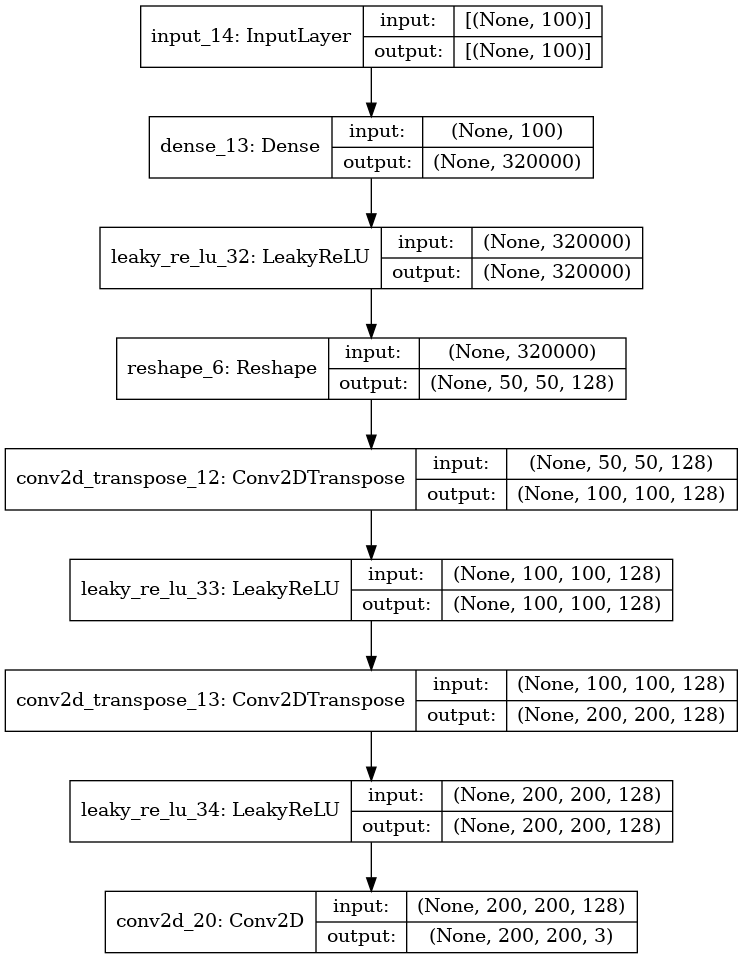

In [58]:
g_model= define_generator(100)
plot_model(g_model, show_shapes=True)


In [59]:
def define_gan(g_model, d_model):

    d_model.trainable=False
    gan_output = d_model(g_model.output)
    model = models.Model(g_model.input, gan_output)
    opt = optimizers.Adam(lr=lr, beta_1=0.5)
    model.compile(loss="binary_crossentropy",
                 optimizer=opt)
    return model


In [60]:
# select subset of data of the train with data hashtag.
# for the train supervised.
def select_supervised_samples(dataset, n_samples=100, n_classes=Type_class):
    X, y=dataset
    X_list, y_list=list(), list()
    n_per_class=int(n_samples / n_classes)
    print(X[0].shape)
    print(y.shape)
    for iter in range(0, 2):
    
        X_with_class=X[y == iter]
        ix=np.random.randint(0, len(X_with_class), n_per_class)
        [X_list.append(X_with_class[j]) for j in ix]
        [y_list.append(iter) for j in ix]
        pass
    return np.asarray(X_list), np.asarray(y_list)

In [61]:
# select example samples
def generate_real_samples(dataset, n_samples):
    
    images , labels=dataset
    # select instances random
    ix=np.random.randint(0, images.shape[0], n_samples)
    # select images and hashtag
    X, labels=images[ix], labels[ix]
    # generate class of hashtag
    y=np.ones((n_samples, 1))
    return [X, labels], y

In [62]:
# generate point in the space latent
def generate_latent_points(latent_dim, n_samples):
    # points of the space latent
    z_input=np.random.randn(latent_dim * n_samples)
    z_input=z_input.reshape(n_samples, latent_dim)
    return z_input

# use generator for save samples fake
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate point latent
    z_input=generate_latent_points(latent_dim, n_samples)
    images=generator.predict(z_input)
    # creat hashtag
    y=np.zeros((n_samples, 1))
    return images, y

In [63]:
# generate samples
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):

    X, _=generate_fake_samples(g_model, latent_dim, n_samples)
    # scalar from [-1, 1] to [0, 1]
    X=(X+1)/2.0
    # graph images
    fig = plt.figure(figsize=(10, 10))
    for i in range(100):
    
        plt.subplot(10, 10, i + 1)
        plt.axis('off')
        # show the images
        plt.imshow(X[i, :, :, :], cmap="gray")
        pass
    
    # save the images
    filename1='generated_plot_%04d.png' % (step + 1)
    plt.savefig(filename1)
    plt.show()
    plt.close()
    
    # try the model of clasificator
    X, y=dataset
    _, acc=c_model.evaluate(x=X, y=y, verbose=1)
    print('rendimiento de clasificacion: %.3f%%' % (acc * 100))
    
    # save the model generator
    filename2='g_model_%04d.h5' % (step + 1)
    g_model.save(filename2)
    
    # save the model of classificator
    filename3='c_model_%04d.h5' % (step + 1)
    c_model.save(filename3)
    print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))
    pass

In [64]:
# train the discriminato and the generator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
    
    # select the set of data supervised
    X_sup, y_sup=select_supervised_samples(dataset)
    print(X_sup.shape, y_sup.shape)

    # calculate the number of batch for epochs of train.
    bat_per_epo=int(dataset[0].shape[0] / n_batch)
    print()
    
    # calculate the number of iterations in the train.
    n_steps=bat_per_epo * n_epochs

    # calculate the size for batch.
    half_batch=int(n_batch / 2)
    print("n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d" % (n_epochs, 
                                                                 n_batch,
                                                                 half_batch,
                                                                 bat_per_epo,
                                                                 n_steps))
    
    # enumerate epochs
    for i in range(n_steps):
        
        # actualized of discriminator supervised.
        [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
        c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)        

        # actualized the disciminator not supervised.
        [X_real, _], y_real = generate_real_samples(dataset, half_batch)
        d_loss1 = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)
        
        # actualized generator
        X_gan, y_gan=generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
        g_loss=gan_model.train_on_batch(X_gan, y_gan)
        
        # resume of loss for batch
        print(">%d, c[%.3f, %.0f], d[%.3f, %.3f], g[%.3f]" % (i + 1, c_loss, c_acc * 100, d_loss1, d_loss2, g_loss))
        
        if (i + 1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, c_model, latent_dim, dataset)
    

(1600, 200, 200, 3, 1)
(1600, 200, 200, 3) (1600,)
(200, 200, 3)
(1600,)
(16, 200, 200, 3) (16,)

n_epochs=20, n_batch=100, 1/2=50, b/e=16, steps=320
>1, c[2.314, 44], d[0.000, 2.501], g[0.112]
>2, c[1.059, 52], d[0.002, 2.298], g[0.193]
>3, c[12.833, 50], d[0.683, 1.470], g[0.498]
>4, c[4.029, 48], d[0.000, 1.189], g[0.574]
>5, c[20.083, 32], d[0.000, 0.835], g[0.922]
>6, c[2.279, 60], d[0.000, 0.529], g[1.550]
>7, c[7.469, 62], d[0.000, 0.397], g[2.503]
>8, c[10.368, 52], d[0.128, 0.262], g[3.570]
>9, c[9.109, 48], d[0.258, 3.616], g[4.138]
>10, c[6.098, 44], d[0.024, 0.020], g[5.280]
>11, c[0.461, 76], d[8.145, 3.548], g[0.047]
>12, c[0.927, 46], d[0.100, 3.347], g[0.255]
>13, c[1.228, 64], d[0.000, 2.691], g[1.979]
>14, c[1.576, 58], d[0.000, 0.589], g[3.820]
>15, c[1.245, 48], d[0.077, 0.143], g[4.184]
>16, c[3.116, 50], d[1.541, 8.373], g[0.020]


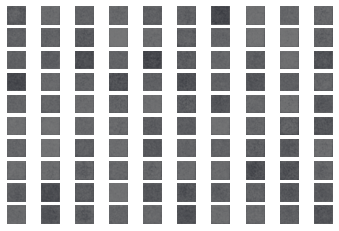

50/50 [==============================] - 1s 16ms/step - loss: 0.9454 - accuracy: 0.9581
rendimiento de clasificacion: 95.812%
>Saved: generated_plot_0016.png, g_model_0016.h5, and c_model_0016.h5
>17, c[1.383, 94], d[0.000, 5.039], g[0.108]
>18, c[2.516, 46], d[0.000, 2.926], g[0.587]
>19, c[1.956, 66], d[0.006, 0.672], g[2.900]
>20, c[1.391, 56], d[1.164, 1.491], g[0.455]
>21, c[3.001, 30], d[0.102, 1.914], g[1.393]
>22, c[0.427, 70], d[0.010, 0.358], g[3.741]
>23, c[0.358, 84], d[1.193, 1.678], g[0.613]
>24, c[0.423, 70], d[0.026, 1.033], g[2.120]
>25, c[0.358, 100], d[0.633, 0.444], g[1.779]
>26, c[0.391, 68], d[0.519, 0.801], g[1.638]
>27, c[0.312, 100], d[0.463, 0.571], g[1.931]
>28, c[0.259, 90], d[0.542, 0.669], g[2.186]
>29, c[0.266, 88], d[0.413, 0.635], g[3.284]
>30, c[0.252, 90], d[0.808, 1.012], g[2.758]
>31, c[0.250, 100], d[0.745, 0.396], g[2.557]
>32, c[0.191, 100], d[0.558, 0.762], g[2.958]


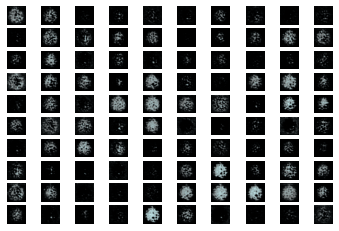

50/50 [==============================] - 1s 17ms/step - loss: 0.3104 - accuracy: 0.9362
rendimiento de clasificacion: 93.625%
>Saved: generated_plot_0032.png, g_model_0032.h5, and c_model_0032.h5
>33, c[0.307, 94], d[1.143, 0.368], g[1.750]
>34, c[0.221, 100], d[0.394, 0.777], g[2.328]
>35, c[0.172, 100], d[0.807, 0.481], g[2.281]
>36, c[0.206, 100], d[0.522, 0.458], g[2.640]
>37, c[0.144, 100], d[0.757, 0.422], g[2.434]
>38, c[0.150, 100], d[0.535, 0.408], g[2.350]
>39, c[0.141, 100], d[0.477, 0.318], g[2.220]
>40, c[0.098, 100], d[0.616, 0.491], g[1.932]
>41, c[0.108, 100], d[0.440, 0.294], g[2.026]
>42, c[0.136, 100], d[0.449, 0.363], g[1.977]
>43, c[0.109, 100], d[0.373, 0.235], g[2.240]
>44, c[0.119, 100], d[0.596, 0.461], g[2.337]
>45, c[0.103, 100], d[0.540, 0.251], g[1.995]
>46, c[0.089, 100], d[0.412, 0.340], g[2.053]
>47, c[0.106, 100], d[0.650, 0.502], g[2.070]
>48, c[0.096, 100], d[0.663, 0.390], g[2.105]


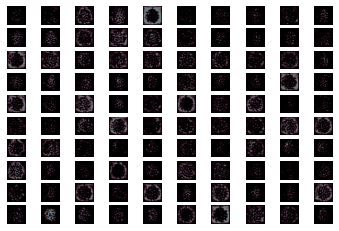

50/50 [==============================] - 1s 16ms/step - loss: 0.2517 - accuracy: 0.9237
rendimiento de clasificacion: 92.375%
>Saved: generated_plot_0048.png, g_model_0048.h5, and c_model_0048.h5
>49, c[0.245, 93], d[0.702, 0.489], g[2.332]
>50, c[0.123, 100], d[0.950, 0.513], g[2.018]
>51, c[0.088, 100], d[0.707, 0.554], g[2.156]
>52, c[0.073, 100], d[0.597, 0.331], g[2.314]
>53, c[0.066, 100], d[0.510, 0.374], g[2.956]
>54, c[0.084, 100], d[0.405, 0.169], g[2.636]
>55, c[0.093, 100], d[0.493, 0.400], g[2.463]
>56, c[0.053, 100], d[0.435, 0.293], g[2.342]
>57, c[0.053, 100], d[0.373, 0.322], g[2.288]
>58, c[0.062, 100], d[0.392, 0.347], g[2.260]
>59, c[0.052, 100], d[0.457, 0.485], g[2.354]
>60, c[0.037, 100], d[0.563, 0.456], g[2.108]
>61, c[0.042, 100], d[0.457, 0.497], g[2.517]
>62, c[0.050, 100], d[0.704, 0.359], g[2.248]
>63, c[0.046, 100], d[0.506, 0.571], g[2.697]
>64, c[0.044, 100], d[0.775, 0.289], g[2.094]


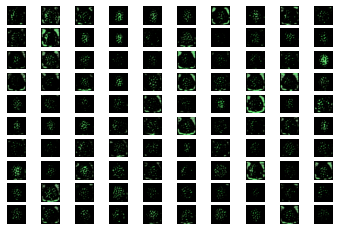

50/50 [==============================] - 1s 16ms/step - loss: 0.2180 - accuracy: 0.9312
rendimiento de clasificacion: 93.125%
>Saved: generated_plot_0064.png, g_model_0064.h5, and c_model_0064.h5
>65, c[0.213, 93], d[0.372, 0.402], g[2.559]
>66, c[0.045, 100], d[0.405, 0.216], g[2.665]
>67, c[0.050, 100], d[0.563, 0.485], g[2.591]
>68, c[0.053, 100], d[0.422, 0.259], g[2.027]
>69, c[0.035, 100], d[0.441, 0.450], g[1.964]
>70, c[0.043, 100], d[0.548, 0.511], g[1.853]
>71, c[0.049, 100], d[0.641, 0.509], g[1.597]
>72, c[0.036, 100], d[0.423, 0.439], g[1.836]
>73, c[0.050, 100], d[0.474, 0.410], g[2.010]
>74, c[0.034, 100], d[0.654, 0.515], g[1.853]
>75, c[0.052, 100], d[0.429, 0.344], g[2.158]
>76, c[0.057, 100], d[0.674, 0.408], g[2.244]
>77, c[0.033, 100], d[0.627, 0.522], g[2.307]
>78, c[0.057, 100], d[0.745, 0.434], g[2.320]
>79, c[0.036, 100], d[0.657, 0.352], g[2.377]
>80, c[0.040, 100], d[0.563, 0.381], g[2.478]


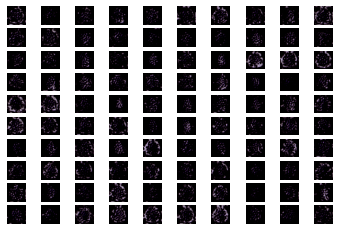

50/50 [==============================] - 1s 17ms/step - loss: 0.1761 - accuracy: 0.9519
rendimiento de clasificacion: 95.187%
>Saved: generated_plot_0080.png, g_model_0080.h5, and c_model_0080.h5
>81, c[0.172, 95], d[0.567, 0.496], g[2.385]
>82, c[0.041, 100], d[0.833, 0.496], g[1.925]
>83, c[0.040, 100], d[0.594, 0.546], g[2.040]
>84, c[0.037, 100], d[0.575, 0.398], g[2.098]
>85, c[0.042, 100], d[0.808, 0.477], g[2.180]
>86, c[0.031, 100], d[0.532, 0.322], g[2.443]
>87, c[0.033, 100], d[0.905, 0.479], g[2.529]
>88, c[0.030, 100], d[0.400, 0.314], g[2.687]
>89, c[0.030, 100], d[0.459, 0.492], g[3.927]
>90, c[0.022, 100], d[0.717, 0.198], g[2.423]
>91, c[0.033, 100], d[0.303, 0.392], g[2.045]
>92, c[0.021, 100], d[0.257, 0.277], g[2.145]
>93, c[0.017, 100], d[0.481, 0.349], g[1.794]
>94, c[0.022, 100], d[0.501, 0.415], g[1.801]
>95, c[0.022, 100], d[0.374, 0.285], g[1.956]
>96, c[0.017, 100], d[0.345, 0.314], g[2.120]


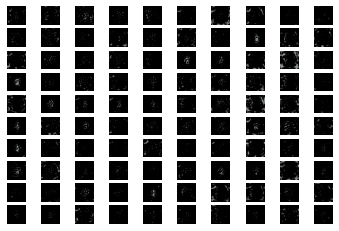

50/50 [==============================] - 1s 16ms/step - loss: 0.2852 - accuracy: 0.8950
rendimiento de clasificacion: 89.500%
>Saved: generated_plot_0096.png, g_model_0096.h5, and c_model_0096.h5
>97, c[0.277, 90], d[0.420, 0.252], g[2.037]
>98, c[0.016, 100], d[0.458, 0.582], g[2.193]
>99, c[0.013, 100], d[0.423, 0.282], g[2.318]
>100, c[0.020, 100], d[0.629, 0.278], g[2.004]
>101, c[0.014, 100], d[0.387, 0.369], g[2.111]
>102, c[0.016, 100], d[0.749, 0.328], g[1.915]
>103, c[0.020, 100], d[0.440, 0.400], g[2.190]
>104, c[0.015, 100], d[0.504, 0.335], g[2.257]
>105, c[0.011, 100], d[0.403, 0.281], g[2.179]
>106, c[0.024, 100], d[0.434, 0.359], g[2.301]
>107, c[0.017, 100], d[0.464, 0.348], g[2.174]
>108, c[0.020, 100], d[0.596, 0.414], g[1.930]
>109, c[0.015, 100], d[0.390, 0.594], g[2.827]
>110, c[0.011, 100], d[0.872, 0.224], g[2.175]
>111, c[0.019, 100], d[0.455, 0.334], g[2.019]
>112, c[0.028, 100], d[0.435, 0.315], g[2.009]


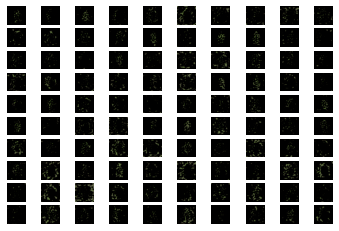

50/50 [==============================] - 1s 17ms/step - loss: 0.2855 - accuracy: 0.9006
rendimiento de clasificacion: 90.062%
>Saved: generated_plot_0112.png, g_model_0112.h5, and c_model_0112.h5
>113, c[0.277, 90], d[0.316, 0.313], g[2.034]
>114, c[0.024, 100], d[0.288, 0.245], g[2.292]
>115, c[0.014, 100], d[0.462, 0.291], g[2.014]
>116, c[0.023, 100], d[0.289, 0.267], g[2.184]
>117, c[0.019, 100], d[0.588, 0.375], g[2.328]
>118, c[0.013, 100], d[0.396, 0.183], g[2.370]
>119, c[0.018, 100], d[0.484, 0.245], g[2.225]
>120, c[0.016, 100], d[0.548, 0.435], g[2.327]
>121, c[0.024, 100], d[0.601, 0.232], g[2.331]
>122, c[0.023, 100], d[0.321, 0.325], g[2.282]
>123, c[0.022, 100], d[0.446, 0.356], g[1.996]
>124, c[0.020, 100], d[0.470, 0.478], g[2.229]
>125, c[0.023, 100], d[0.507, 0.278], g[2.232]
>126, c[0.017, 100], d[0.490, 0.338], g[2.066]
>127, c[0.020, 100], d[0.478, 0.385], g[2.017]
>128, c[0.018, 100], d[0.388, 0.249], g[2.385]


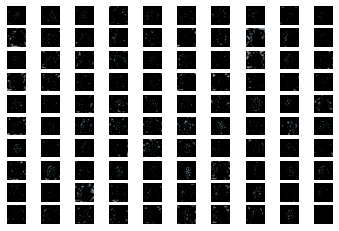

50/50 [==============================] - 1s 16ms/step - loss: 0.2291 - accuracy: 0.9256
rendimiento de clasificacion: 92.563%
>Saved: generated_plot_0128.png, g_model_0128.h5, and c_model_0128.h5
>129, c[0.223, 93], d[0.461, 0.302], g[2.023]
>130, c[0.023, 100], d[0.314, 0.266], g[2.004]
>131, c[0.019, 100], d[0.405, 0.279], g[1.987]
>132, c[0.015, 100], d[0.379, 0.290], g[1.899]
>133, c[0.024, 100], d[0.395, 0.303], g[1.964]
>134, c[0.018, 100], d[0.372, 0.261], g[2.089]
>135, c[0.017, 100], d[0.519, 0.385], g[1.908]
>136, c[0.016, 100], d[0.513, 0.406], g[1.954]
>137, c[0.014, 100], d[0.490, 0.291], g[2.128]
>138, c[0.014, 100], d[0.591, 0.422], g[1.878]
>139, c[0.013, 100], d[0.475, 0.347], g[1.943]
>140, c[0.013, 100], d[0.531, 0.294], g[1.847]
>141, c[0.014, 100], d[0.433, 0.341], g[1.979]
>142, c[0.015, 100], d[0.346, 0.310], g[2.227]
>143, c[0.012, 100], d[0.733, 0.308], g[1.890]
>144, c[0.017, 100], d[0.340, 0.289], g[2.185]


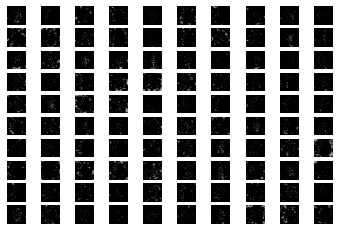

50/50 [==============================] - 1s 16ms/step - loss: 1.6707 - accuracy: 0.6137
rendimiento de clasificacion: 61.375%
>Saved: generated_plot_0144.png, g_model_0144.h5, and c_model_0144.h5
>145, c[1.621, 63], d[0.475, 0.251], g[2.082]
>146, c[0.011, 100], d[0.286, 0.253], g[2.266]
>147, c[0.017, 100], d[0.468, 0.229], g[2.063]
>148, c[0.020, 100], d[0.160, 0.174], g[2.357]
>149, c[0.014, 100], d[0.397, 0.205], g[2.185]
>150, c[0.010, 100], d[0.451, 0.254], g[2.092]
>151, c[0.011, 100], d[0.329, 0.218], g[2.181]
>152, c[0.011, 100], d[0.273, 0.189], g[2.311]
>153, c[0.017, 100], d[0.356, 0.215], g[2.183]
>154, c[0.018, 100], d[0.339, 0.242], g[2.205]
>155, c[0.010, 100], d[0.396, 0.304], g[2.391]
>156, c[0.012, 100], d[0.563, 0.261], g[2.053]
>157, c[0.012, 100], d[0.233, 0.250], g[2.311]
>158, c[0.015, 100], d[0.432, 0.253], g[2.150]
>159, c[0.012, 100], d[0.358, 0.285], g[2.314]
>160, c[0.010, 100], d[0.688, 0.325], g[1.890]


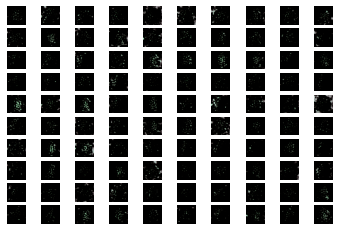

50/50 [==============================] - 1s 16ms/step - loss: 1.9890 - accuracy: 0.6506
rendimiento de clasificacion: 65.062%
>Saved: generated_plot_0160.png, g_model_0160.h5, and c_model_0160.h5
>161, c[1.929, 66], d[0.372, 0.358], g[2.078]
>162, c[0.012, 100], d[0.425, 0.305], g[2.030]
>163, c[0.016, 100], d[0.400, 0.312], g[2.070]
>164, c[0.010, 100], d[0.467, 0.278], g[2.268]
>165, c[0.012, 100], d[0.701, 0.342], g[2.039]
>166, c[0.017, 100], d[0.554, 0.314], g[2.146]
>167, c[0.011, 100], d[0.273, 0.195], g[2.394]
>168, c[0.010, 100], d[0.535, 0.245], g[2.229]
>169, c[0.010, 100], d[0.424, 0.260], g[2.402]
>170, c[0.017, 100], d[0.443, 0.234], g[2.308]
>171, c[0.019, 100], d[0.348, 0.228], g[2.301]
>172, c[0.010, 100], d[0.227, 0.217], g[2.359]
>173, c[0.009, 100], d[0.399, 0.222], g[2.095]
>174, c[0.009, 100], d[0.335, 0.242], g[2.085]
>175, c[0.009, 100], d[0.330, 0.243], g[2.044]
>176, c[0.013, 100], d[0.233, 0.220], g[2.189]


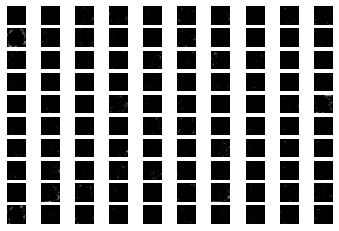

50/50 [==============================] - 1s 17ms/step - loss: 3.1634 - accuracy: 0.5444
rendimiento de clasificacion: 54.438%
>Saved: generated_plot_0176.png, g_model_0176.h5, and c_model_0176.h5
>177, c[3.068, 56], d[0.428, 0.215], g[2.051]
>178, c[0.012, 100], d[0.284, 0.189], g[2.167]
>179, c[0.009, 100], d[0.267, 0.162], g[2.267]
>180, c[0.016, 100], d[0.384, 0.194], g[2.045]
>181, c[0.012, 100], d[0.324, 0.220], g[2.033]
>182, c[0.006, 100], d[0.267, 0.227], g[2.197]
>183, c[0.015, 100], d[0.387, 0.271], g[2.098]
>184, c[0.027, 100], d[0.153, 0.160], g[2.484]
>185, c[0.015, 100], d[0.411, 0.220], g[2.120]
>186, c[0.008, 100], d[0.364, 0.211], g[2.091]
>187, c[0.011, 100], d[0.364, 0.225], g[2.049]
>188, c[0.014, 100], d[0.406, 0.234], g[2.056]
>189, c[0.011, 100], d[0.341, 0.206], g[2.162]
>190, c[0.014, 100], d[0.466, 0.254], g[1.937]
>191, c[0.006, 100], d[0.423, 0.285], g[1.990]
>192, c[0.008, 100], d[0.437, 0.274], g[2.113]


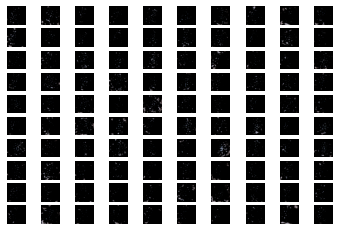

50/50 [==============================] - 1s 17ms/step - loss: 2.7120 - accuracy: 0.6012
rendimiento de clasificacion: 60.125%
>Saved: generated_plot_0192.png, g_model_0192.h5, and c_model_0192.h5
>193, c[2.630, 61], d[0.237, 0.219], g[2.276]
>194, c[0.006, 100], d[0.484, 0.248], g[2.198]
>195, c[0.006, 100], d[0.261, 0.178], g[2.415]
>196, c[0.008, 100], d[0.395, 0.206], g[2.215]
>197, c[0.012, 100], d[0.332, 0.274], g[2.377]
>198, c[0.010, 100], d[0.462, 0.235], g[2.075]
>199, c[0.016, 100], d[0.305, 0.238], g[2.276]
>200, c[0.014, 100], d[0.520, 0.274], g[2.138]
>201, c[0.009, 100], d[0.403, 0.311], g[2.421]
>202, c[0.025, 100], d[0.565, 0.326], g[2.438]
>203, c[0.013, 100], d[0.400, 0.218], g[2.562]
>204, c[0.014, 100], d[0.344, 0.190], g[2.791]
>205, c[0.009, 100], d[0.580, 0.248], g[2.520]
>206, c[0.014, 100], d[0.371, 0.209], g[2.747]
>207, c[0.008, 100], d[0.446, 0.200], g[2.494]
>208, c[0.007, 100], d[0.256, 0.186], g[2.710]


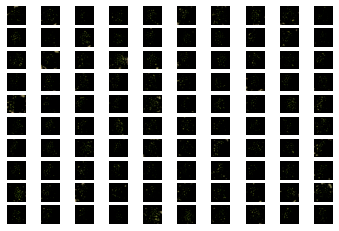

50/50 [==============================] - 1s 18ms/step - loss: 3.4146 - accuracy: 0.5581
rendimiento de clasificacion: 55.813%
>Saved: generated_plot_0208.png, g_model_0208.h5, and c_model_0208.h5
>209, c[3.311, 57], d[0.461, 0.207], g[2.245]
>210, c[0.007, 100], d[0.325, 0.246], g[2.251]
>211, c[0.007, 100], d[0.232, 0.161], g[2.401]
>212, c[0.017, 100], d[0.499, 0.237], g[2.072]
>213, c[0.016, 100], d[0.218, 0.221], g[2.314]
>214, c[0.021, 100], d[0.376, 0.253], g[2.170]
>215, c[0.008, 100], d[0.244, 0.187], g[2.396]
>216, c[0.012, 100], d[0.373, 0.204], g[2.189]
>217, c[0.014, 100], d[0.175, 0.155], g[2.472]
>218, c[0.016, 100], d[0.187, 0.116], g[2.651]
>219, c[0.009, 100], d[0.167, 0.094], g[2.731]
>220, c[0.007, 100], d[0.315, 0.124], g[2.594]
>221, c[0.007, 100], d[0.331, 0.136], g[2.349]
>222, c[0.008, 100], d[0.358, 0.162], g[2.281]
>223, c[0.007, 100], d[0.162, 0.133], g[2.487]
>224, c[0.006, 100], d[0.349, 0.141], g[2.310]


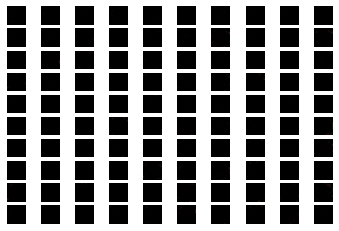

50/50 [==============================] - 1s 16ms/step - loss: 3.5397 - accuracy: 0.5813
rendimiento de clasificacion: 58.125%
>Saved: generated_plot_0224.png, g_model_0224.h5, and c_model_0224.h5
>225, c[3.433, 59], d[0.374, 0.182], g[2.164]
>226, c[0.010, 100], d[0.217, 0.168], g[2.309]
>227, c[0.009, 100], d[0.472, 0.208], g[2.104]
>228, c[0.017, 100], d[0.203, 0.190], g[2.272]
>229, c[0.012, 100], d[0.227, 0.154], g[2.416]
>230, c[0.012, 100], d[0.185, 0.128], g[2.554]
>231, c[0.014, 100], d[0.349, 0.176], g[2.216]
>232, c[0.012, 100], d[0.155, 0.138], g[2.607]
>233, c[0.009, 100], d[0.243, 0.099], g[2.597]
>234, c[0.005, 100], d[0.197, 0.125], g[2.559]
>235, c[0.010, 100], d[0.195, 0.108], g[2.567]
>236, c[0.008, 100], d[0.370, 0.134], g[2.310]
>237, c[0.015, 100], d[0.286, 0.143], g[2.291]
>238, c[0.007, 100], d[0.256, 0.145], g[2.411]
>239, c[0.005, 100], d[0.115, 0.099], g[2.687]
>240, c[0.006, 100], d[0.167, 0.084], g[2.765]


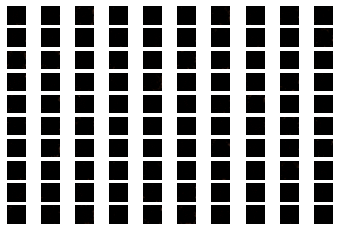

50/50 [==============================] - 1s 16ms/step - loss: 3.4243 - accuracy: 0.6244
rendimiento de clasificacion: 62.437%
>Saved: generated_plot_0240.png, g_model_0240.h5, and c_model_0240.h5
>241, c[3.321, 64], d[0.268, 0.099], g[2.600]
>242, c[0.006, 100], d[0.240, 0.112], g[2.519]
>243, c[0.006, 100], d[0.291, 0.131], g[2.446]
>244, c[0.006, 100], d[0.194, 0.140], g[2.474]
>245, c[0.005, 100], d[0.169, 0.111], g[2.621]
>246, c[0.009, 100], d[0.247, 0.109], g[2.619]
>247, c[0.009, 100], d[0.303, 0.144], g[2.504]
>248, c[0.003, 100], d[0.256, 0.136], g[2.528]
>249, c[0.009, 100], d[0.270, 0.160], g[2.494]
>250, c[0.008, 100], d[0.227, 0.162], g[2.570]
>251, c[0.004, 100], d[0.173, 0.100], g[2.872]
>252, c[0.009, 100], d[0.216, 0.111], g[2.878]
>253, c[0.007, 100], d[0.178, 0.107], g[2.825]
>254, c[0.006, 100], d[0.301, 0.153], g[2.461]
>255, c[0.014, 100], d[0.330, 0.152], g[2.463]
>256, c[0.013, 100], d[0.352, 0.139], g[2.339]


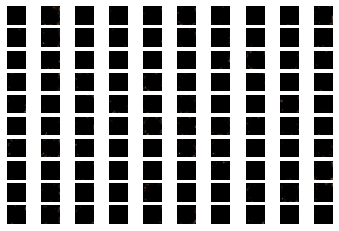

50/50 [==============================] - 1s 17ms/step - loss: 2.3597 - accuracy: 0.7200
rendimiento de clasificacion: 72.000%
>Saved: generated_plot_0256.png, g_model_0256.h5, and c_model_0256.h5
>257, c[2.289, 73], d[0.262, 0.129], g[2.434]
>258, c[0.002, 100], d[0.342, 0.140], g[2.183]
>259, c[0.071, 100], d[0.235, 0.300], g[2.296]
>260, c[0.250, 86], d[0.577, 0.173], g[2.346]
>261, c[0.007, 100], d[0.068, 0.243], g[3.239]
>262, c[0.010, 100], d[0.815, 0.210], g[2.166]
>263, c[0.131, 98], d[0.641, 0.291], g[2.091]
>264, c[0.006, 100], d[0.253, 0.207], g[2.657]
>265, c[0.018, 100], d[0.563, 0.463], g[2.386]
>266, c[0.019, 100], d[0.525, 0.627], g[4.736]
>267, c[0.084, 100], d[1.389, 0.051], g[2.623]
>268, c[0.008, 100], d[0.386, 0.395], g[2.778]
>269, c[0.004, 100], d[0.248, 0.060], g[3.267]
>270, c[0.006, 100], d[0.394, 0.118], g[2.660]
>271, c[0.005, 100], d[0.330, 0.150], g[2.408]
>272, c[0.011, 100], d[0.186, 0.132], g[2.559]


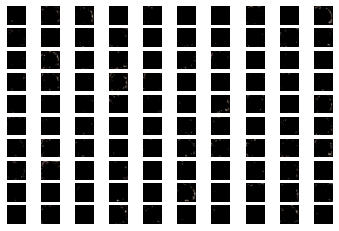

50/50 [==============================] - 1s 19ms/step - loss: 0.7053 - accuracy: 0.8506
rendimiento de clasificacion: 85.062%
>Saved: generated_plot_0272.png, g_model_0272.h5, and c_model_0272.h5
>273, c[0.684, 86], d[0.258, 0.138], g[2.564]
>274, c[0.001, 100], d[0.289, 0.132], g[2.455]
>275, c[0.004, 100], d[0.221, 0.134], g[2.530]
>276, c[0.003, 100], d[0.244, 0.117], g[2.584]
>277, c[0.002, 100], d[0.202, 0.114], g[2.574]
>278, c[0.003, 100], d[0.355, 0.183], g[2.468]
>279, c[0.002, 100], d[0.288, 0.131], g[2.479]
>280, c[0.003, 100], d[0.267, 0.137], g[2.456]
>281, c[0.002, 100], d[0.162, 0.112], g[2.655]
>282, c[0.002, 100], d[0.245, 0.101], g[2.676]
>283, c[0.003, 100], d[0.314, 0.137], g[2.452]
>284, c[0.001, 100], d[0.225, 0.140], g[2.501]
>285, c[0.001, 100], d[0.456, 0.163], g[2.307]
>286, c[0.003, 100], d[0.214, 0.153], g[2.505]
>287, c[0.003, 100], d[0.223, 0.117], g[2.600]
>288, c[0.002, 100], d[0.389, 0.138], g[2.330]


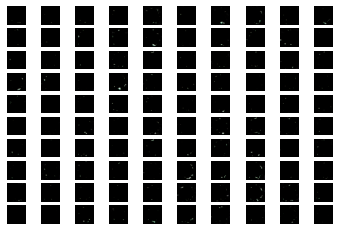

50/50 [==============================] - 1s 16ms/step - loss: 0.9122 - accuracy: 0.8562
rendimiento de clasificacion: 85.625%
>Saved: generated_plot_0288.png, g_model_0288.h5, and c_model_0288.h5
>289, c[0.885, 86], d[0.165, 0.136], g[2.450]
>290, c[0.002, 100], d[0.168, 0.119], g[2.602]
>291, c[0.003, 100], d[0.120, 0.089], g[2.804]
>292, c[0.002, 100], d[0.177, 0.086], g[2.829]
>293, c[0.002, 100], d[0.229, 0.090], g[2.779]
>294, c[0.001, 100], d[0.239, 0.122], g[2.670]
>295, c[0.002, 100], d[0.295, 0.141], g[2.632]
>296, c[0.002, 100], d[0.162, 0.102], g[2.872]
>297, c[0.002, 100], d[0.227, 0.115], g[2.758]
>298, c[0.001, 100], d[0.232, 0.110], g[2.863]
>299, c[0.001, 100], d[0.182, 0.109], g[2.944]
>300, c[0.001, 100], d[0.326, 0.123], g[2.610]
>301, c[0.003, 100], d[0.130, 0.155], g[3.035]
>302, c[0.001, 100], d[0.071, 0.094], g[3.317]
>303, c[0.003, 100], d[0.435, 0.126], g[2.424]
>304, c[0.004, 100], d[0.495, 0.363], g[2.594]


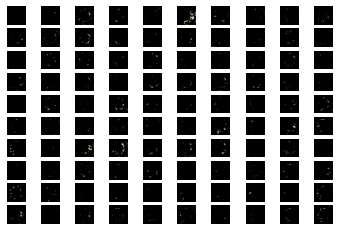

50/50 [==============================] - 1s 17ms/step - loss: 1.4215 - accuracy: 0.8081
rendimiento de clasificacion: 80.813%
>Saved: generated_plot_0304.png, g_model_0304.h5, and c_model_0304.h5
>305, c[1.378, 81], d[0.223, 0.261], g[3.207]
>306, c[0.003, 100], d[0.495, 0.216], g[2.637]
>307, c[0.003, 100], d[0.375, 0.757], g[3.194]
>308, c[0.001, 100], d[0.321, 0.428], g[4.510]
>309, c[0.001, 100], d[0.611, 0.496], g[4.230]
>310, c[0.001, 100], d[1.034, 0.348], g[3.297]
>311, c[0.001, 100], d[0.750, 0.265], g[3.294]
>312, c[0.003, 100], d[0.531, 0.376], g[4.092]
>313, c[0.002, 100], d[0.457, 0.388], g[3.282]
>314, c[0.004, 100], d[0.545, 0.429], g[3.103]
>315, c[0.005, 100], d[0.367, 0.376], g[2.926]
>316, c[0.045, 98], d[0.331, 0.344], g[2.811]
>317, c[0.023, 100], d[0.288, 0.196], g[2.599]
>318, c[0.001, 100], d[0.436, 0.331], g[2.534]
>319, c[0.001, 100], d[0.414, 0.267], g[2.618]
>320, c[0.002, 100], d[0.480, 0.204], g[2.788]


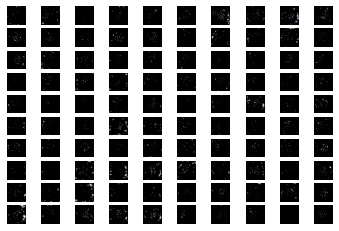

50/50 [==============================] - 1s 16ms/step - loss: 2.2762 - accuracy: 0.6450
rendimiento de clasificacion: 64.500%
>Saved: generated_plot_0320.png, g_model_0320.h5, and c_model_0320.h5


In [65]:
# tamaño del espacio latente
latent_dim = 100
# crear modelos discriminadores
d_model, c_model = define_discriminator()
# crear el generador
g_model = define_generator(latent_dim)
# crear el gan
gan_model = define_gan(g_model, d_model)
# cargar los datos 
dataset = load_real_samples(trainX, trainy)
# entrenar el modelo
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

In [73]:
def load_samples(featureX, targety):
    
    # expand to 3 dimensions
    X = np.expand_dims(featureX, axis=-1)
    print(X.shape)
    print(targety.shape)
    X=featureX.astype('float32')
    
    X=np.asarray(X)
    X=normalize(X)
    
    #X=X[:, :, :, 0]
    #R, G, B = X.shape
    #X = X.reshape(R, G, B, 1)
    # Escale from [0,255] to [-1, 1]
    X = (X - np.amin(X)) / (np.amax(X) - np.amin(X))*-1
    
    if len(targety.shape) == 2:
        
        trainy = targety[:, 0]
    else:
        trainy = targety
    
    print(X.shape, targety.shape)
    return [X, trainy]

In [74]:

model = models.load_model("./c_model_0128.h5")
#trainX = np.expand_dims(trainX, axis = -1)
#testX = np.expand_dims(testX, axis = -1)

#trainX= trainX.astype('float32')
#testX = testX.astype('float32')

#trainX = np.asarray(trainX)
#testX = np.asarray(testX)

#trainX = normalize(trainX)
#testX = normalize(testX)

#trainX = trainX[:, :, :, 0]
#print(trainX.shape)
#R, G, B, _ = trainX.shape
#trainX = trainX.reshape(R, G, B, 1)
#trainX = (trainX - np.amin(trainX)) / (np.amax(trainX) - np.amin(trainX)) * - 1

#testX = testX[:, :, :, 0] 
#R, G, B, _ = testX.shape
#testX = testX.reshape(R, G, B, 1)
#testX = (testX - np.amin(testX)) / (np.amax(testX) - np.amin(testX)) * - 1

trainX, trainy = load_samples(trainX, trainy)
testX, testy = load_samples(testX, testy)

_, train_acc = model.evaluate(trainX, trainy, verbose=1)
print('Train Accuracy: %.3f%%' % (train_acc * 100))
_, test_acc = model.evaluate(testX, testy, verbose=1)
print('Test Accuracy: %.3f%%' % (test_acc * 100))


(1600, 200, 200, 3, 1)
(1600, 12)
(1600, 200, 200, 3) (1600, 12)
(400, 200, 200, 3, 1)
(400, 12)
(400, 200, 200, 3) (400, 12)
50/50 [==============================] - 1s 16ms/step - loss: 0.1952 - accuracy: 0.9287
Train Accuracy: 92.875%
13/13 [==============================] - 0s 19ms/step - loss: 0.2553 - accuracy: 0.8850
Test Accuracy: 88.500%
